In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [2]:
# Download training data from open datasets.
training_data = datasets.STL10(
    root="~/work/data",
    split='train',
    download=False,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.STL10(
    root="~/work/data",
    split='test',
    download=False,
    transform=ToTensor(),
)

In [3]:
import random

def normalize_and_resize_img():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # VGG-16 표준 정규화
    ])

def augment():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2)
    ])

def augment2():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.RandomRotation(degrees=(0, 90)),  # 90도 단위 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 밝기, 대비, 색상 조정
        transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),  # 랜덤 크롭 후 리사이즈
    ])

# 데이터셋을 가공하는 메인함수
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, with_heavy_aug=False):
    transform = normalize_and_resize_img()

    if not is_test and with_aug:
        dataset.transform = transforms.Compose([
            *augment().transforms,
            *transform.transforms
        ])
        if with_heavy_aug:
            dataset.transform = transforms.Compose([
            *augment2().transforms,
            *transform.transforms
        ])
            
    else:
        dataset.transform = transform

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

In [4]:
batch_size = 16

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# augmentation
#train_dataloader_aug = apply_normalize_on_dataset(training_data, is_test=False, batch_size=16, with_aug=True, with_heavy_aug=False)


# heavy augmentation
#train_dataloader_haug = apply_normalize_on_dataset(training_data, is_test=False, batch_size=16, with_aug=True, with_heavy_aug=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 3, 96, 96])
Shape of y: torch.Size([16]) torch.int64


In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [5]:
from torchvision import datasets, transforms, models  
vgg_16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)                                                                     
vgg_16.classifier[6] = nn.Linear(4096, 10)                                                                                            


In [ ]:
#vgg_16_nopre = models.vgg16()                                                                     
#vgg_16_nopre.classifier[6] = nn.Linear(4096, 10)  

In [17]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [6]:
from torchinfo import summary

summary(vgg_16, input_size=(16,3,96,96))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [16, 10]                  --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 96, 96]          1,792
│    └─ReLU: 2-2                         [16, 64, 96, 96]          --
│    └─Conv2d: 2-3                       [16, 64, 96, 96]          36,928
│    └─ReLU: 2-4                         [16, 64, 96, 96]          --
│    └─MaxPool2d: 2-5                    [16, 64, 48, 48]          --
│    └─Conv2d: 2-6                       [16, 128, 48, 48]         73,856
│    └─ReLU: 2-7                         [16, 128, 48, 48]         --
│    └─Conv2d: 2-8                       [16, 128, 48, 48]         147,584
│    └─ReLU: 2-9                         [16, 128, 48, 48]         --
│    └─MaxPool2d: 2-10                   [16, 128, 24, 24]         --
│    └─Conv2d: 2-11                      [16, 256, 24, 24]         29

In [7]:
import torch.optim as optim

def train(model, train_loader, test_loader, epochs):
    model.to(device)
    history = {'val_accuracy': []}
    history['train_accuracy']= []
    history['val_loss']= []
    history['train_loss']= []
    train_num_batches = len(train_loader)
    test_num_batches = len(test_loader)

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
        test_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_loss += loss.item()
        train_loss /= train_num_batches
        history['train_loss'].append(train_loss)

        train_acc = 100. * correct / total
        history['train_accuracy'].append(train_acc)
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%, Loss: {train_loss:.5f}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                loss = criterion(outputs, labels)

                test_loss += loss.item()
        test_loss /= test_num_batches
        history['val_loss'].append(test_loss)

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%, Loss: {test_loss:.5f}")

    return history



In [10]:
%%time
import torch.optim as optim
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=1e-3)

history_vgg16 = train(vgg_16, train_dataloader, test_dataloader, EPOCH)

Epoch [1/20], Accuracy: 75.12%, Loss: 0.75056
Validation Accuracy: 88.80%, Loss: 0.32307
Epoch [2/20], Accuracy: 90.16%, Loss: 0.29462
Validation Accuracy: 90.55%, Loss: 0.27288
Epoch [3/20], Accuracy: 93.48%, Loss: 0.19660
Validation Accuracy: 91.49%, Loss: 0.24670
Epoch [4/20], Accuracy: 95.42%, Loss: 0.13812
Validation Accuracy: 91.92%, Loss: 0.24471
Epoch [5/20], Accuracy: 96.32%, Loss: 0.11064
Validation Accuracy: 91.62%, Loss: 0.25099
Epoch [6/20], Accuracy: 97.50%, Loss: 0.07625
Validation Accuracy: 92.01%, Loss: 0.25087
Epoch [7/20], Accuracy: 98.26%, Loss: 0.05323
Validation Accuracy: 91.78%, Loss: 0.26693
Epoch [8/20], Accuracy: 98.88%, Loss: 0.03548
Validation Accuracy: 92.15%, Loss: 0.27949
Epoch [9/20], Accuracy: 99.18%, Loss: 0.02664
Validation Accuracy: 92.30%, Loss: 0.27527
Epoch [10/20], Accuracy: 99.30%, Loss: 0.02204
Validation Accuracy: 92.49%, Loss: 0.28563
Epoch [11/20], Accuracy: 99.46%, Loss: 0.02068
Validation Accuracy: 92.31%, Loss: 0.30112
Epoch [12/20], Accu

In [11]:
torch.save(vgg_16, "./vgg_16_model.pth")
torch.save(vgg_16.state_dict(), "./vgg_16_model_weights.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [12]:
import pickle

# save data
with open('./vgg_16_model_history.pickle','wb') as fw:
    pickle.dump(history_vgg16, fw)


In [13]:

# load data
with open('./vgg_16_model_history.pickle', 'rb') as fr:
    history_vgg16 = pickle.load(fr)

with open('./vgg_16_aug_model_history.pickle', 'rb') as fr:
    history_vgg16_aug = pickle.load(fr)

with open('./vgg_16_haug_model_history.pickle', 'rb') as fr:
    history_vgg16_haug = pickle.load(fr)


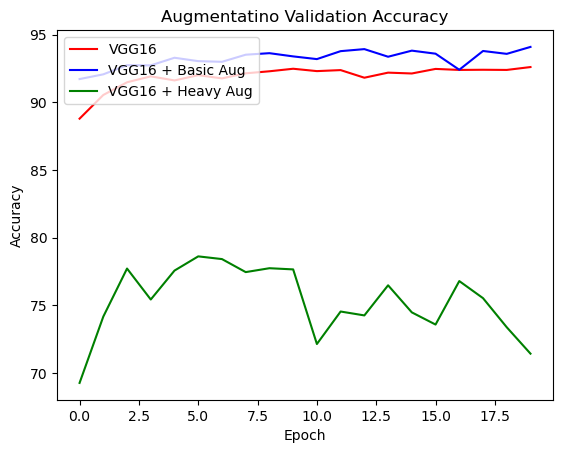

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_vgg16['val_accuracy'], 'r', label="VGG16")
plt.plot(history_vgg16_aug['val_accuracy'], 'b', label="VGG16 + Basic Aug")
plt.plot(history_vgg16_haug['val_accuracy'], 'g', label="VGG16 + Heavy Aug")


plt.title('Augmentatino Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

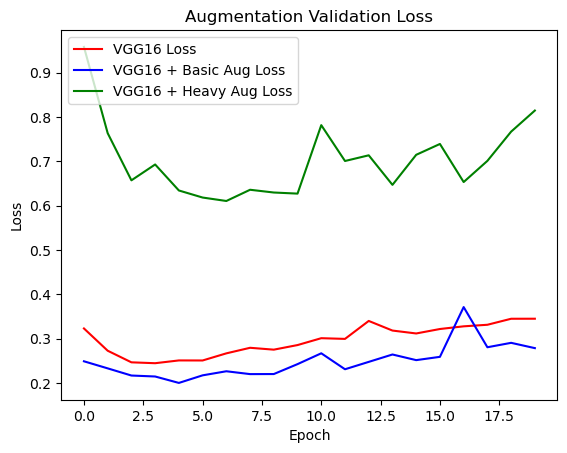

In [19]:
plt.plot(history_vgg16['val_loss'], 'r', label="VGG16 Loss")
plt.plot(history_vgg16_aug['val_loss'], 'b', label="VGG16 + Basic Aug Loss")
plt.plot(history_vgg16_haug['val_loss'], 'g', label="VGG16 + Heavy Aug Loss")


plt.title('Augmentation Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()